# Portfolio Management : Extra Credit Project (Fall 2020)
## Leena Dighole

In [ ]:
'''
Project Title: Portfolio performance analysis by varying different model parameters

Specifications:
1. Benchmark = SP500

2. Models used:
    1)LSTM RNN (4 layers with 2 LSTM RNN layers)
    2)LSTM RNN (5 layers with 3 LSTM RNN layers)
    3)LSTM RNN (6 layers with 4 LSTM RNN layers)

3. Models performance Analysis:
    1)RMSE-Root Mean Square Error
    2)MAE- Mean Absolute Error
    
Different Cases:
1. Varying No of LSTM layers
2. Varying dropout rates
3. Different batch size
4. Different epoch size
5. varing rolling window sizes
6. Different optimising techniques
7. Different loss functions for training the model
8. Different no of nodes in hidden layers

    
Program Flexibility:
1. Flexibility of selection of no of stocks to construct portfolio
    Here you can select any no of stocks like top 'assets' stocks by Market capitalization(eg top 30 stocks)
2. Rolling window size selection
    User can select any no of window size 'window' to analyse differences in performances of model
3. Flexibility of training the model using today's stock prices
    The end date of downloading data is not hard coded for the reason that this code should be used at any time to 
    get up to  date results meaning the end date is set todays date and the data for our assets will be downloaded for todays date
    This gives the flexibility to train our model with the recent dataset to get better predictions
4. Flexibility of selecting Alpha model
    LSTM_RNN with different LSTM layers and dropout values
5.Flexibility of user choosing daily returns or monthly returns for the predictions


Lets Surf the code!
    

'''

In [ ]:
#Note if these packages are not installed earlier then kindly install them one by one before running the code
#installing package for portfolio optimization
pip install PyPortfolioOpt

#installing packages for yahoo finance
pip install yfinance
pip install yahoo_fin
pip install requests_html

#Installing model support packages
pip install tensorflow
pip install keras
pip install scikit-learn
pip install xgboost

In [1]:
#Import Essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data
from datetime import datetime
import yfinance as yf 
from yahoo_fin.stock_info import *

#Plotting size
plt.style.use('fivethirtyeight')

In [2]:
# Import Libraries for Model Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [3]:
#Libraries for Optimization
from pypfopt.efficient_frontier  import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from scipy import optimize
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy.optimize import Bounds

In [4]:
#Import Libraries for Model space
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


In [5]:
#Get the stock data for benchmark
class Data_InputSpace(object):
    '''
    Aim:The data collection of the Sp500 benchmark portfolio
    To Do:
    1.Download the data(daily closing prices) for all tickers in SP500 index from yahoo finance
    2.Calculate top 30 stocks by market Capitalization
    3.We will use these 30 stocks for expected return predictions
    Note: The data is downloaded from 2013-01-01 till todays date. This is done to be able to use all data upto todays date for predictions
    
    '''
    
    def __init__(self):  #initialization
        self.t = []                 #Storing stock tickers of SP500
        self.stockname =[]          #Storing stock n
        self.data_df = pd.DataFrame()    #storing adjusted closing day price of stocks
    
        
        
    def get_tickers(self): 
        '''
        Make the list of all tickers present in SP500 index.
        There are total 505 tickers in this index.
        '''
        self.t=tickers_sp500()
       # print('tickers',self.t)
        return self.t
    
    def get_data(self,stocknames): 
        '''
        Download the closing daily stock prices of the stocks in Sp500
        Remove the tickers from the list whose data is unavailable on yahoo finance
        Note: Start date is '2013-01-01' and end date will be todays date to be able to utilize all latest information for predictions
        '''
        self.stockname = stocknames
        #For calculating beta we need SP500 index historical data too
        self.stockname.append('^GSPC')
        
        #Download Daily closing prices
        self.stockStartDate = '2013-01-01'   #start date
        self.today = datetime.today().strftime('%Y-%m-%d')    #to get todays date
        self.data_df = yf.download(self.stockname,start= self.stockStartDate ,end = self.today)['Adj Close'][1:] 
        print('stock data frame\n',self.data_df)
        return self.data_df
    
    def top_30_stocks(self,stocknames,assets):
        '''
        Calculate top 30 stocks by market capitalization
        Use these stocks data for predicting expected returns of new portfolio
        '''
        self.stockname = stocknames
        self.mcaps = pd.DataFrame()   #storing market capitalization of stocks
        self.top_stock_no = int(assets)
      
        self.mcaps=data.get_quote_yahoo(self.stockname)['marketCap']   
        mcaps = self.mcaps
        print('Market Capitaization of stocks are:\n',self.mcaps)
        
        #Sort data to find top 30 stocks
        self.sorted_mcaps = sorted(mcaps.items(),key = lambda mcaps:mcaps[1],reverse =True)
        self.top_30_stocklist = self.sorted_mcaps[: self.top_stock_no]
        print('Top', assets,' stocklist using Market capitalisation is:\n',self.top_30_stocklist)
        return self.top_30_stocklist
                
                
        
    def data_processing(self,assets):
        '''
        1.collect stock names and corresponding tickers of the SP500
        2.Top 30 stocks with market capitalization are calculated for developing our portfolio
        3.Daily adjacent closing data of top 30 stocks is downloaded using yahoo finance
        '''
        stocknames = self.get_tickers()
        
        #Remove the stock names whose data is not present for given date periods
        self.fail =['BRK.B','BF.B','ZTS','VTRS','WY']
        for j in self.fail:
            try:
                stocknames.remove(j)
            except:
                None
        
        #Calculate top 30 stocks by market capitalization and download their historical daily closing prices
        self.top_30_stocklist= self.top_30_stocks(stocknames,assets)
        self.top_30_stocknames = [i[0] for i in self.top_30_stocklist]
        print('top_30_stocknames \n',self.top_30_stocknames)
        self.historical_data = self.get_data(self.top_30_stocknames)
        
        return self.top_30_stocknames,self.historical_data

              
    
        

In [7]:
#Collect top 30 stocks and corresponding historical data
assets = input('Enter the no of top assets by Market capitalization to be used to construct portfolio:   ')
obj1 = Data_InputSpace()
top_30_stocks,historical_dataset = obj1.data_processing(int(assets))

#Top 30 stickers used for portfolio construction are:
# ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'GOOG', 'FB', 'V', 'WMT', 'JNJ', 'JPM', 'MA', 'PG', 'NVDA', 'UNH', 'HD', 'DIS', 'PYPL', 'VZ', 'BAC', 'CMCSA', 'ADBE', 'KO', 'PFE', 'NFLX', 'NKE', 'INTC', 'T', 'MRK', 'CRM', 'PEP']

Enter the no of top assets by Market capitalization to be used to construct portfolio:   5
Market Capitaization of stocks are:
 A         35996569600
AAL        9564721152
AAP       10902859776
AAPL    2243727458304
ABBV     182236348416
            ...      
XYL       18068258816
YUM       32441376768
ZBH       30936242176
ZBRA      20094418944
ZION       7108280320
Name: marketCap, Length: 500, dtype: int64
Top 5  stocklist using Market capitalisation is:
 [('AAPL', 2243727458304), ('MSFT', 1684101398528), ('AMZN', 1591900372992), ('GOOG', 1174579183616), ('GOOGL', 1174577872896)]
top_30_stocknames 
 ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'GOOGL']
[*********************100%***********************]  6 of 6 completed
stock data frame
                   AAPL         AMZN         GOOG        GOOGL        MSFT  \
Date                                                                        
2013-01-03   16.849854   258.480011   360.483826   362.197205   22.870243   
2013-01-04   16.380503   259.1

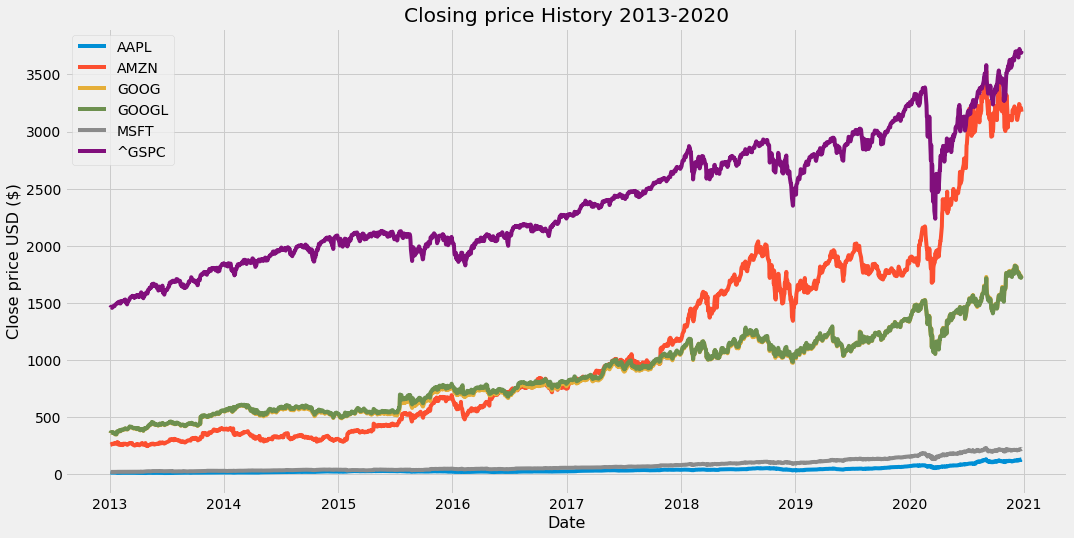

In [8]:
#Visualise the closing price history
plt.figure(figsize=(16,8))
plt.title('Closing price History 2013-2020')
plt.plot(historical_dataset)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close price USD ($)', fontsize =16)
plt.legend(historical_dataset.columns)

In [9]:
#Calculate Monthly simple returns
'''
Motivation: The statistical properties of the returns over prices is useful to be used in predicting future returns
Formula: (Pt/Pt-1)-1
Simple returns are the percentage change in the price (Pt) at time t compared to previous price (Pt-1) at time t-1
The percentage change of prices is also refered as normalizing data to be able to measure all variables in a comparable metrics
'''
user = int(input('Enter the user preference for returns\n 1. Daily returns\n 2. Monthly returns\n'))
if user== 1:
    simple_returns = historical_dataset.pct_change()
elif user== 2:
    simple_returns = historical_dataset.resample('M').ffill().pct_change()
print('The Simple returns of the top 30 stocks are:\n',simple_returns)

Enter the user preference for returns
 1. Daily returns
 2. Monthly returns
1
The Simple returns of the top 30 stocks are:
                 AAPL      AMZN      GOOG     GOOGL      MSFT     ^GSPC
Date                                                                  
2013-01-03       NaN       NaN       NaN       NaN       NaN       NaN
2013-01-04 -0.027855  0.002592  0.019760  0.019760 -0.018715  0.004865
2013-01-07 -0.005882  0.035925 -0.004363 -0.004363 -0.001870 -0.003123
2013-01-08  0.002692 -0.007748 -0.001974 -0.001973 -0.005246 -0.003242
2013-01-09 -0.015629 -0.000113  0.006573  0.006573  0.005650  0.002656
...              ...       ...       ...       ...       ...       ...
2020-12-18 -0.015851 -0.010639 -0.009663 -0.008210 -0.003783 -0.003511
2020-12-21  0.012395  0.001415  0.004830  0.004831  0.018299 -0.003906
2020-12-22  0.028465  0.000106 -0.009124 -0.008267  0.006065 -0.002073
2020-12-23 -0.006976 -0.006627  0.005152  0.004656 -0.013039  0.000746
2020-12-24  0.007712 -0.

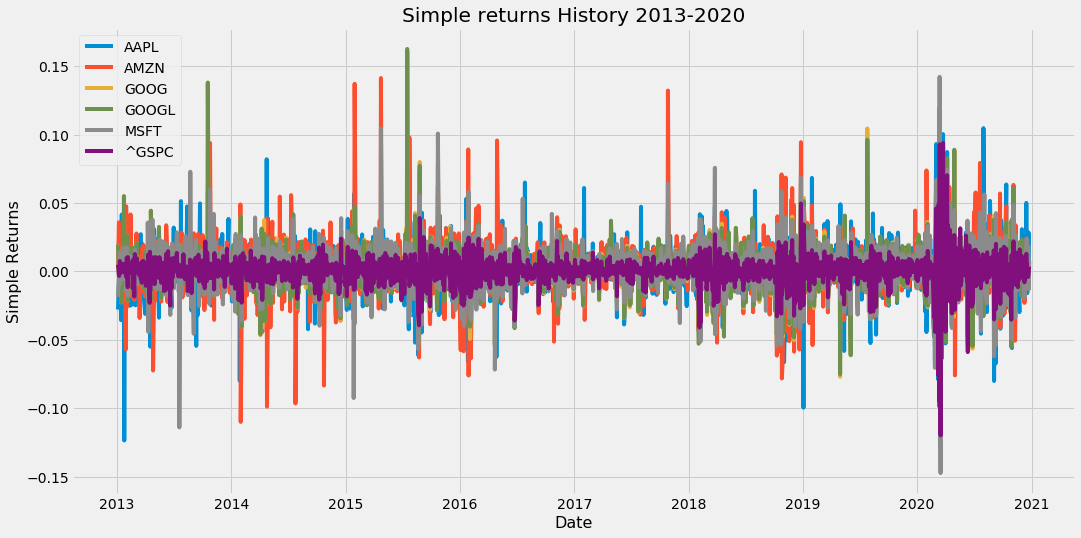

In [10]:
#Visualise the Simple returns history
plt.figure(figsize=(16,8))
plt.title('Simple returns History 2013-2020')
plt.plot(historical_dataset.pct_change())
plt.xlabel('Date', fontsize=16)
plt.ylabel('Simple Returns', fontsize =16)
plt.legend(historical_dataset.columns)

In [11]:
#As we normalized the data using simple returns,lets use log normal returns
'''
Motivation: We assume that prices of the stocks are distributed log normally.
The log normal returns log(1+ri) are assumed to be normally distributed, where ri is the simple return
Properties:
1. log(1+rt) = log(Pt)-log(pt-1)
2. If returns are very small r<<1, log(1+r) ~ r ....r<<<1
3. The simple additive property of logs can be used to avoid complex calculations for compound returns.
'''
log_returns = np.log(1+ simple_returns)
print('log returns are:\n',log_returns)


log returns are:
                 AAPL      AMZN      GOOG     GOOGL      MSFT     ^GSPC
Date                                                                  
2013-01-03       NaN       NaN       NaN       NaN       NaN       NaN
2013-01-04 -0.028250  0.002589  0.019568  0.019568 -0.018893  0.004853
2013-01-07 -0.005900  0.035295 -0.004373 -0.004373 -0.001872 -0.003128
2013-01-08  0.002688 -0.007778 -0.001975 -0.001975 -0.005259 -0.003248
2013-01-09 -0.015753 -0.000113  0.006552  0.006552  0.005634  0.002652
...              ...       ...       ...       ...       ...       ...
2020-12-18 -0.015978 -0.010696 -0.009710 -0.008244 -0.003790 -0.003517
2020-12-21  0.012319  0.001414  0.004818  0.004820  0.018134 -0.003914
2020-12-22  0.028067  0.000106 -0.009166 -0.008302  0.006047 -0.002075
2020-12-23 -0.007000 -0.006649  0.005139  0.004646 -0.013125  0.000746
2020-12-24  0.007683 -0.003957  0.003728  0.003425  0.007797  0.003530

[2010 rows x 6 columns]


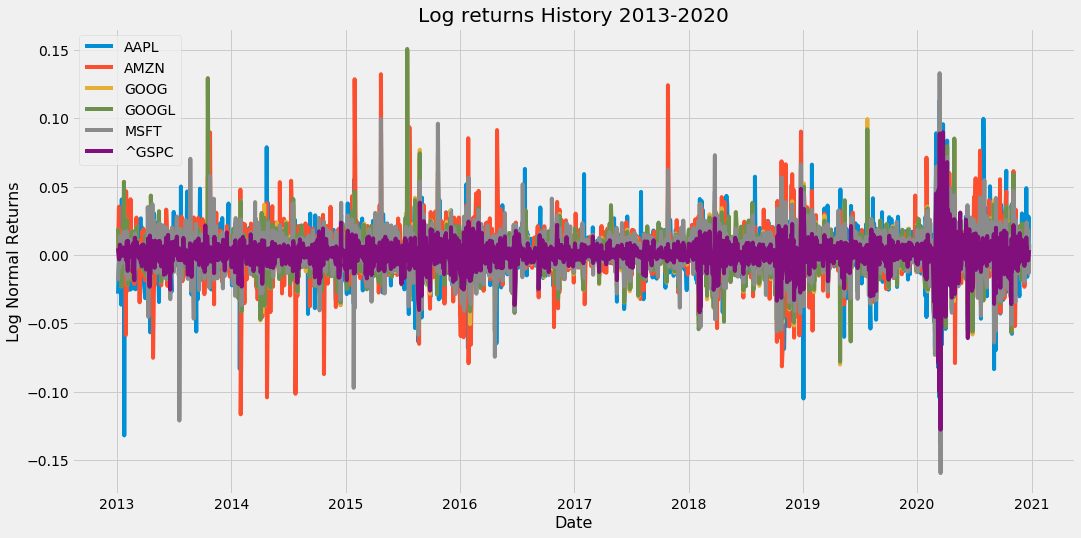

In [12]:
#Visualise the log returns history
plt.figure(figsize=(16,8))
plt.title('Log returns History 2013-2020')
plt.plot(log_returns)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Log Normal Returns', fontsize =16)
plt.legend(historical_dataset.columns)

In [ ]:
'''
Observations:
Notice that due to similar statistical features of simple returns and log normal returns,
we can use any one of them for our further data processing.
In this project the log returns are used for predicting future returns
Notice that the mean of returns are 0 and the prediction will allow us to get an intuition about whether
the price will go up or down the following day.
'''

In [13]:
#Drop NAN values from log returns while processing data
return_dataset=log_returns.fillna(0)
#print(return_dataset)
new_return_dataset = return_dataset.drop('^GSPC',axis=1)
print(new_return_dataset )


                AAPL      AMZN      GOOG     GOOGL      MSFT
Date                                                        
2013-01-03  0.000000  0.000000  0.000000  0.000000  0.000000
2013-01-04 -0.028250  0.002589  0.019568  0.019568 -0.018893
2013-01-07 -0.005900  0.035295 -0.004373 -0.004373 -0.001872
2013-01-08  0.002688 -0.007778 -0.001975 -0.001975 -0.005259
2013-01-09 -0.015753 -0.000113  0.006552  0.006552  0.005634
...              ...       ...       ...       ...       ...
2020-12-18 -0.015978 -0.010696 -0.009710 -0.008244 -0.003790
2020-12-21  0.012319  0.001414  0.004818  0.004820  0.018134
2020-12-22  0.028067  0.000106 -0.009166 -0.008302  0.006047
2020-12-23 -0.007000 -0.006649  0.005139  0.004646 -0.013125
2020-12-24  0.007683 -0.003957  0.003728  0.003425  0.007797

[2010 rows x 5 columns]


In [14]:
#Training-Testing data set splitting
class Split_dataset(object):
    '''
    1.Convert closing date stock returns from dataframe into numpy arrays for splitting
    2.Scale the data between (0,1) using minmax scaling
    3.Split the data set into training (80%)and testing data(20%)
    4.Create x_train and y_train variables using rolling window size = 250
    '''
    
    def __init__(self,log_returns,window):  #Initialization
        self.h_dataset = log_returns
        self.window=int(window)   # dynamic rolling window size
        self.x_train =[]    #storing x_training data 
        self.y_train =[]    #storing y_training data 
        self.x_test =[]    #storing x_testing data 
       # self.y_test =[]     #storing y_testing data
        self.scaler = MinMaxScaler(feature_range=(0,1))
        
        
    def Minmax_scaler(self,log_returns,window):
        '''
        Motivation: The scaling of features is performed which includes robustness to very small deviations of features.
        The scaling enables us to preserve zero entries in sparse data.
        Feature scaling represents the significance of the features in th eprocess of selecting most significant features.
        Note we have 30 features and we are scaling them between [0,1] using minmax scaling
        Result:
        Note that our top 30 stocks selected as features are significant by seeing the scaled version of log returns of historical data. 
        '''
      
        #Convert dataframe to numpy array before splitting data
        self.dataset_values=log_returns.values
        #print('The array conversion of original dataset:\n',self.dataset_values)
            

        #Calculate no of rows to train the model
        self.training_dataset_len = math.ceil(len(self.dataset_values)* .8)   #80% training data
        print('The training dataset length is:',self.training_dataset_len)

        #Scale the data

        self.scaled_data = self.scaler.fit_transform(self.dataset_values)
        #print(self.scaled_data[:5])
        #print(self.scaled_data)
        
        #y =[x[0] for x in self.scaled_data]
        #print('y\n',y)
        return self.scaled_data
    
    def Create_training_data(self,log_returns,window):
        '''
        Lets look at our input and output space dimensions.
        Rolling window training dataset dimension will look like,
        x_train = [60*30]
        y_train =[1*30]
        where,
        60 is total no of rows in x_train input data rrepresenting data of past 60 days
        30 represents total no of features of data which are top 30 stocks in this project.
        '''
        #create the scaled training data set
        self.scaled_data = self.Minmax_scaler(log_returns,window)
        self.train_data = self.scaled_data[0:self.training_dataset_len , :]
        #print('self.train_data:\n',self.train_data)
        
        #Split the data into x_train and y_train datasets using 60 days rolling window
        for i in range(self.window, len(self.train_data)):
            self.x_train.append(self.train_data[i-self.window:i, :])   #scaled data of 60 days
            self.y_train.append(self.train_data[i, :])         #scaled data of 61st day
            
            #Lets take a look of our x_train and y_train dataset for first rolling window
            if i<= 10:
                print('**************************************************** \n')
                print('The first rolling window Training data will look like:\n')
                print('x_train \n',self.x_train)
                print('y_train \n',self.y_train)
              
        
        #Convert x_train and y_train dataset to numpy array for training modelspace
        self.x_train,self.y_train = np.array(self.x_train),np.array(self.y_train)
        print('x_train array:\n',self.x_train)
        print('y_train array:\n',self.y_train)
        
        return self.x_train,self.y_train
    
    def Create_testing_data(self,log_returns,window):
        '''
        Create the test data sets- x_test and y_test similar to training dataset 
        '''
        #Create the scaled test data
        self.test_data = self.scaled_data[self.training_dataset_len-self.window: , :]  
        print('Length of Test dataset is: ',len(self.dataset_values) -self.training_dataset_len )
        
        #Create the datasets x_test and y_test
        self.y_test = self.dataset_values[self.training_dataset_len:, :]
        for i in range (self.window, len(self.test_data)):
            self.x_test.append(self.train_data[i-self.window:i, :])   #scaled data of 60 days
            
            #Lets see the testing dataset for first rolling window
            if i<= 10:
                print('**************************************************** \n')
                print('The first rolling window test data will look like:\n')
                print('x_test \n',self.x_test)
                print('y_test \n',self.y_test[0])
               
                
        #Convert x_test and y_test dataset to numpy array for training modelspace
        self.x_test,self.y_test = np.array(self.x_test),np.array(self.y_test)
        print('x_test array:\n',self.x_test)
        print('y_test array:\n',self.y_test)
        
                
        return self.x_test,self.y_test

        
            
            
            
         
      
            
            
        


In [15]:
# Train-Test Splitting
window = input('Enter the rolling window size for LSTM model:')   #User input for rolling window size

obj2=Split_dataset(new_return_dataset,window)
x_train,y_train = obj2.Create_training_data(new_return_dataset,window)
x_test,y_test = obj2.Create_testing_data(new_return_dataset,window)

Enter the rolling window size for LSTM model:100
The training dataset length is: 1608
x_train array:
 [[[0.5489317  0.46848364 0.44146333 0.45086078 0.54535892]
  [0.43632078 0.47889319 0.51487716 0.52218958 0.48074258]
  [0.52541388 0.61041206 0.42505737 0.43492069 0.53895771]
  ...
  [0.55606006 0.45070546 0.41339166 0.42358618 0.49959558]
  [0.57597671 0.46756197 0.40099884 0.4115459  0.5573558 ]
  [0.51557113 0.55285941 0.47546227 0.48389398 0.61940298]]

 [[0.43632078 0.47889319 0.51487716 0.52218958 0.48074258]
  [0.52541388 0.61041206 0.42505737 0.43492069 0.53895771]
  [0.55964712 0.43720653 0.43405171 0.44366011 0.5273709 ]
  ...
  [0.57597671 0.46756197 0.40099884 0.4115459  0.5573558 ]
  [0.51557113 0.55285941 0.47546227 0.48389398 0.61940298]
  [0.58050089 0.44191778 0.38587947 0.3968556  0.5316581 ]]

 [[0.52541388 0.61041206 0.42505737 0.43492069 0.53895771]
  [0.55964712 0.43720653 0.43405171 0.44366011 0.5273709 ]
  [0.48613895 0.46803075 0.46604328 0.47474269 0.5646280

In [16]:
#Lets check the shape of x_train, y_train ,x_test, y_test
'''
LSTM modelspace requires 3-D data which are:
1. Samples
2.Time steps
3.Features
Note that our above x_train data is a 3-D LSTM compatible data
The time steps refers to how many steps in time we want the backpropagation algorithm to use when calculating gradients for
weight updates during training phase of model.
'''
x_shape = x_train.shape
print('The x_train dimensions are:\n',x_shape)

y_shape = y_train.shape
print('The y_train dimensions are:\n',y_shape)

x_testshape = x_test.shape
print('The x_test dimensions are:\n',x_testshape)

y_testshape = y_test.shape
print('The y_test dimensions are:\n',y_testshape)

scaler = MinMaxScaler(feature_range=(0,1))

The x_train dimensions are:
 (1508, 100, 5)
The y_train dimensions are:
 (1508, 5)
The x_test dimensions are:
 (402, 100, 5)
The y_test dimensions are:
 (402, 5)


In [22]:
#Model Space 1 (4 layers model)
#LSTM RNN model to predict future returns of the top 11 stocks
class LSTM_RNN_ModelSpace_1(object):
    
    def __init__(self,x_train_set,y_train_set,x_test_set,y_test_set,log_returns): #initialization
        self.x_train = x_train_set
        self.y_train = y_train_set
        self.x_test = x_test_set
        self.y_test = y_test_set
        #Create a sequential RNN model
        self.model = Sequential()
      
        

        
    def Create_LSTM_model(self,x_train_set,y_train_set,assets,dropout):
        '''
        Motivation: Create an LSTM RNN model to predict future returns
        Sequential models have plain stack of layers with one i/p and one o/p tensor
        
        Keywords:
        1.Batch = batch size of training data used for Stochastic Gradient descent optimization
        2.Epoch = no of times the model will be passed through the given training data set
        
        To Do: 
        A) LSTM RNN Model Construction:
        1)First  LSTM model Layer:
            *Number of nodes = 50
            *We want return sequences =True to be able to add next layer
            *Input shape consists of no of time steps and no of features
                Here no of time stpes = size of rolling window = 60
                and No of features = top 30 stocks = 30
        2)Second LSTM layer:
            *Number of nodes = 50
            *We want return sequences= False as we want to use 2 LSTM layer model in this project
        
        3)We will add certain dense layers after LSTM in our RNN model
            *Third layer will be a dense layer with 25 nodes
            *Forth layer will be one dense layer
                    
        '''
        
        #First LSTM Layer
        self.model.add(LSTM(50, return_sequences = True, input_shape = (self.x_train.shape[1], self.x_train.shape[2])))
        self.model.add(Dropout(dropout))
        
        #Second LSTM layer
        self.model.add(LSTM(50, return_sequences = False))  #We are using 2 LSTM layers only
        self.model.add(Dropout(dropout))
        
        #Add a dense layer with nodes =25
        self.model.add(Dense(25))
        self.model.add(Dropout(dropout))
        
        #Add a dense layer with node = 1
        self.model.add(Dense(1))
               
        #Compile the model using Adam optimizer and MSE as a loss function
        self.model.compile(optimizer = 'adam',loss ='mean_squared_error')
        
        #Train the LSTM RNN model
        '''
        The no of epochs were selected by running the model with different epoch sizes.
        For epoch 1 , loss = 0.0089
        for epoch 5, loss = 0.0069
        for epoch 8, loss = 0.0069
        For epoch 10, loss = 0.0068
        
        Here we can observe that the loss value is not changing drastically from epoch 5 to 10 
        and we can say that the convergence may have occured and choose the epoch 10 for our further calculations.
        
        Case 1: batch_size =1 and epoch =10
        Entire dataset is passed in each epoch iteration
        Results: 
        Epoch 1/10
        1036/1036 [==============================] - 26s 25ms/step - loss: 0.0089
        Epoch 2/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0072
        Epoch 3/10
        1036/1036 [==============================] - 26s 25ms/step - loss: 0.0071 0s -
        Epoch 4/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0070
        Epoch 5/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0069
        Epoch 6/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0069
        Epoch 7/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0069
        Epoch 8/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0068
        Epoch 9/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0069
        Epoch 10/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0068
        
        case 2: batch_size = 3 and epoch =10
        The randomly choosen 1/3rd of the entire dataset is passed in each epoch iteration
        
        Epoch 1/10
        346/346 [==============================] - 15s 42ms/step - loss: 0.0082
        Epoch 2/10
        346/346 [==============================] - 15s 42ms/step - loss: 0.0069
        Epoch 3/10
        346/346 [==============================] - 17s 48ms/step - loss: 0.0070
        Epoch 4/10
        346/346 [==============================] - 17s 48ms/step - loss: 0.0070
        Epoch 5/10
        346/346 [==============================] - 17s 48ms/step - loss: 0.0070
        Epoch 6/10
        346/346 [==============================] - 17s 48ms/step - loss: 0.0070
        Epoch 7/10
        346/346 [==============================] - 16s 46ms/step - loss: 0.0070
        Epoch 8/10
        346/346 [==============================] - 17s 49ms/step - loss: 0.0069
        Epoch 9/10
        346/346 [==============================] - 16s 48ms/step - loss: 0.0068
        Epoch 10/10
        346/346 [==============================] - 17s 49ms/step - loss: 0.0069
        
        Note that above 2 examples are here to show the differences between selecting different batch size and epoch size
        
        case 3: batch size =10, epoch = 10 (To manage tradeoff between accuracy and computational time)
        
        With observations made from above 2 cases, we will use batch_size = 10 and epoch = 5 to train our model
        '''
        #Train the model using epoch 10
        #We used batch size=1 as we want to pass the entire dataset to the model while training it
        self.model.fit(self.x_train,self.y_train,validation_data=(self.x_test,self.y_test) ,batch_size =10 ,epochs =5)
        
        #Print model summary
        print(self.model.summary())
        return self.model
        
        
    def LSTM_Predictions(self,x_test_set,y_test_set):
       
        '''
        Motivation: Perform predictions of returns using testing dataset
        To do:
        y_test is the log normal return values dataset
        x_test is the scaled values dataset
        Thus we need to take inverse scalar form of the predictions performed by scaled data to get predicted log returns
        For predictions,
        x_test(scaled version) => y_predicted(scaled version) => y_predicted(log returns) using inverse scaling transform
        '''
        #Predictions of scaled data
        #self.model=model
        #self.x_train = x_test_set
        #self.x_train = x_test_set
        
        self.train_predictions = self.model.predict(self.x_train)
        self.test_predictions = self.model.predict(self.x_test)
        #print(' self.train_predictions',  self.train_predictions)
       # print('***********************************************')
        #print(' self.test_predictions',  self.test_predictions)
        
       
        return self.test_predictions,self.test_predictions
    
        
    
    

           

In [23]:
#Model Space 2(5 layers model)
#LSTM RNN model to predict future returns of the top 11 stocks
class LSTM_RNN_ModelSpace_2(object):
    
    def __init__(self,x_train_set,y_train_set,x_test_set,y_test_set,log_returns): #initialization
        self.x_train = x_train_set
        self.y_train = y_train_set
        self.x_test = x_test_set
        self.y_test = y_test_set
        #Create a sequential RNN model
        self.model = Sequential()
      
        

        
    def Create_LSTM_model(self,x_train_set,y_train_set,assets,dropout):
        '''
        Motivation: Create an LSTM RNN model to predict future returns
        Sequential models have plain stack of layers with one i/p and one o/p tensor
        
        Keywords:
        1.Batch = batch size of training data used for Stochastic Gradient descent optimization
        2.Epoch = no of times the model will be passed through the given training data set
        
        To Do: 
        A) LSTM RNN Model Construction:
        1)First  LSTM model Layer:
            *Number of nodes = 50
            *We want return sequences =True to be able to add next layer
            *Input shape consists of no of time steps and no of features
                Here no of time stpes = size of rolling window = 60
                and No of features = top 30 stocks = 30
        2)Second LSTM Layer:
            *Number of nodes = 50
            *We want return sequences =True to be able to add next layer
            *Input shape consists of no of time steps and no of features
                Here no of time stpes = size of rolling window = 60
                and No of features = top 30 stocks = 30
        3)Third LSTM layer:
            *Number of nodes = 50
            *We want return sequences= False as we want to use 2 LSTM layer model in this project
        
        4)We will add certain dense layers after LSTM in our RNN model
            *Third layer will be a dense layer with 25 nodes
            *Forth layer will be one dense layer
                    
        '''
        
        #First LSTM Layer
        self.model.add(LSTM(50, return_sequences = True, input_shape = (self.x_train.shape[1], self.x_train.shape[2])))
        self.model.add(Dropout(dropout))
        
        #Second LSTM Layer
        self.model.add(LSTM(50, return_sequences = True, input_shape = (self.x_train.shape[1], self.x_train.shape[2])))
        self.model.add(Dropout(dropout))
        
        #Third LSTM layer
        self.model.add(LSTM(50, return_sequences = False))  #We are using 2 LSTM layers only
        self.model.add(Dropout(dropout))
        
        #Add a dense layer with nodes =25
        self.model.add(Dense(25))
        self.model.add(Dropout(dropout))
        
        #Add a dense layer with node = 1
        self.model.add(Dense(1))
        
        #Compile the model using Adam optimizer and MSE as a loss function
        self.model.compile(optimizer = 'adam',loss ='mean_squared_error')
        
        #Train the LSTM RNN model
        '''
        The no of epochs were selected by running the model with different epoch sizes.
        For epoch 1 , loss = 0.0089
        for epoch 5, loss = 0.0069
        for epoch 8, loss = 0.0069
        For epoch 10, loss = 0.0068
        
        Here we can observe that the loss value is not changing drastically from epoch 5 to 10 
        and we can say that the convergence may have occured and choose the epoch 10 for our further calculations.
        
        Case 1: batch_size =1 and epoch =10
        Entire dataset is passed in each epoch iteration
        Results: 
        Epoch 1/10
        1036/1036 [==============================] - 26s 25ms/step - loss: 0.0089
        Epoch 2/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0072
        Epoch 3/10
        1036/1036 [==============================] - 26s 25ms/step - loss: 0.0071 0s -
        Epoch 4/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0070
        Epoch 5/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0069
        Epoch 6/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0069
        Epoch 7/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0069
        Epoch 8/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0068
        Epoch 9/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0069
        Epoch 10/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0068
        
        case 2: batch_size = 3 and epoch =10
        The randomly choosen 1/3rd of the entire dataset is passed in each epoch iteration
        
        Epoch 1/10
        346/346 [==============================] - 15s 42ms/step - loss: 0.0082
        Epoch 2/10
        346/346 [==============================] - 15s 42ms/step - loss: 0.0069
        Epoch 3/10
        346/346 [==============================] - 17s 48ms/step - loss: 0.0070
        Epoch 4/10
        346/346 [==============================] - 17s 48ms/step - loss: 0.0070
        Epoch 5/10
        346/346 [==============================] - 17s 48ms/step - loss: 0.0070
        Epoch 6/10
        346/346 [==============================] - 17s 48ms/step - loss: 0.0070
        Epoch 7/10
        346/346 [==============================] - 16s 46ms/step - loss: 0.0070
        Epoch 8/10
        346/346 [==============================] - 17s 49ms/step - loss: 0.0069
        Epoch 9/10
        346/346 [==============================] - 16s 48ms/step - loss: 0.0068
        Epoch 10/10
        346/346 [==============================] - 17s 49ms/step - loss: 0.0069
        
        Note that above 2 examples are here to show the differences between selecting different batch size and epoch size
        
        case 3: batch size =10, epoch = 10 (To manage tradeoff between accuracy and computational time)
        
        With observations made from above 2 cases, we will use batch_size = 10 and epoch = 5 to train our model
        '''
        #Train the model using epoch 10
        #We used batch size=1 as we want to pass the entire dataset to the model while training it
        self.model.fit(self.x_train,self.y_train,validation_data=(self.x_test,self.y_test) ,batch_size =10 ,epochs =5)
        
        #Print model summary
        print(self.model.summary())
        return self.model
        
        
    def LSTM_Predictions(self,x_test_set,y_test_set):
       
        '''
        Motivation: Perform predictions of returns using testing dataset
        To do:
        y_test is the log normal return values dataset
        x_test is the scaled values dataset
        Thus we need to take inverse scalar form of the predictions performed by scaled data to get predicted log returns
        For predictions,
        x_test(scaled version) => y_predicted(scaled version) => y_predicted(log returns) using inverse scaling transform
        '''
        #Predictions of scaled data
        #self.model=model
        #self.x_train = x_test_set
        #self.x_train = x_test_set
        
        self.train_predictions = self.model.predict(self.x_train)
        self.test_predictions = self.model.predict(self.x_test)
        #print(' self.train_predictions',  self.train_predictions)
       # print('***********************************************')
        #print(' self.test_predictions',  self.test_predictions)
        
       
        return self.test_predictions,self.test_predictions
    
        
    
    

           
            
    

In [24]:
#Model Space 3(6 layers model)
#LSTM RNN model to predict future returns of the top 11 stocks
class LSTM_RNN_ModelSpace_3(object):
    
    def __init__(self,x_train_set,y_train_set,x_test_set,y_test_set,log_returns): #initialization
        self.x_train = x_train_set
        self.y_train = y_train_set
        self.x_test = x_test_set
        self.y_test = y_test_set
        #Create a sequential RNN model
        self.model = Sequential()
      
        

        
    def Create_LSTM_model(self,x_train_set,y_train_set,assets,dropout):
        '''
        Motivation: Create an LSTM RNN model to predict future returns
        Sequential models have plain stack of layers with one i/p and one o/p tensor
        
        Keywords:
        1.Batch = batch size of training data used for Stochastic Gradient descent optimization
        2.Epoch = no of times the model will be passed through the given training data set
        
        To Do: 
        A) LSTM RNN Model Construction:
        1)First  LSTM model Layer:
            *Number of nodes = 50
            *We want return sequences =True to be able to add next layer
            *Input shape consists of no of time steps and no of features
                Here no of time stpes = size of rolling window = 60
                and No of features = top 30 stocks = 30
        2)Second and Third LSTM Layer:
            *Number of nodes = 50
            *We want return sequences =True to be able to add next layer
            *Input shape consists of no of time steps and no of features
                Here no of time stpes = size of rolling window = 60
                and No of features = top 30 stocks = 30
        3)Forth LSTM layer:
            *Number of nodes = 50
            *We want return sequences= False as we want to use 2 LSTM layer model in this project
        
        4)We will add certain dense layers after LSTM in our RNN model
            *fifth layer will be a dense layer with 25 nodes
            *sixth layer will be one dense layer
                    
        '''
        
        #First LSTM Layer
        self.model.add(LSTM(50, return_sequences = True, input_shape = (self.x_train.shape[1], self.x_train.shape[2])))
        self.model.add(Dropout(dropout))
        
        #Second LSTM Layer
        self.model.add(LSTM(50, return_sequences = True, input_shape = (self.x_train.shape[1], self.x_train.shape[2])))
        self.model.add(Dropout(dropout))
        
        #Third LSTM Layer
        self.model.add(LSTM(50, return_sequences = True, input_shape = (self.x_train.shape[1], self.x_train.shape[2])))
        self.model.add(Dropout(dropout))
        
        #Forth LSTM layer
        self.model.add(LSTM(50, return_sequences = False))  #We are using 4 LSTM layers only
        self.model.add(Dropout(dropout))
        
        #Add a dense layer with nodes =25
        self.model.add(Dense(25))
        self.model.add(Dropout(dropout))
        
        #Add a dense layer with node = 1
        self.model.add(Dense(1))
        
        #Compile the model using Adam optimizer and MSE as a loss function
        self.model.compile(optimizer = 'adam',loss ='mean_squared_error')
        
        #Train the LSTM RNN model
        '''
        The no of epochs were selected by running the model with different epoch sizes.
        For epoch 1 , loss = 0.0089
        for epoch 5, loss = 0.0069
        for epoch 8, loss = 0.0069
        For epoch 10, loss = 0.0068
        
        Here we can observe that the loss value is not changing drastically from epoch 5 to 10 
        and we can say that the convergence may have occured and choose the epoch 10 for our further calculations.
        
        Case 1: batch_size =1 and epoch =10
        Entire dataset is passed in each epoch iteration
        Results: 
        Epoch 1/10
        1036/1036 [==============================] - 26s 25ms/step - loss: 0.0089
        Epoch 2/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0072
        Epoch 3/10
        1036/1036 [==============================] - 26s 25ms/step - loss: 0.0071 0s -
        Epoch 4/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0070
        Epoch 5/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0069
        Epoch 6/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0069
        Epoch 7/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0069
        Epoch 8/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0068
        Epoch 9/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0069
        Epoch 10/10
        1036/1036 [==============================] - 27s 26ms/step - loss: 0.0068
        
        case 2: batch_size = 3 and epoch =10
        The randomly choosen 1/3rd of the entire dataset is passed in each epoch iteration
        
        Epoch 1/10
        346/346 [==============================] - 15s 42ms/step - loss: 0.0082
        Epoch 2/10
        346/346 [==============================] - 15s 42ms/step - loss: 0.0069
        Epoch 3/10
        346/346 [==============================] - 17s 48ms/step - loss: 0.0070
        Epoch 4/10
        346/346 [==============================] - 17s 48ms/step - loss: 0.0070
        Epoch 5/10
        346/346 [==============================] - 17s 48ms/step - loss: 0.0070
        Epoch 6/10
        346/346 [==============================] - 17s 48ms/step - loss: 0.0070
        Epoch 7/10
        346/346 [==============================] - 16s 46ms/step - loss: 0.0070
        Epoch 8/10
        346/346 [==============================] - 17s 49ms/step - loss: 0.0069
        Epoch 9/10
        346/346 [==============================] - 16s 48ms/step - loss: 0.0068
        Epoch 10/10
        346/346 [==============================] - 17s 49ms/step - loss: 0.0069
        
        Note that above 2 examples are here to show the differences between selecting different batch size and epoch size
        
        case 3: batch size =10, epoch = 10 (To manage tradeoff between accuracy and computational time)
        
        With observations made from above 2 cases, we will use batch_size = 10 and epoch = 5 to train our model
        '''
        #Train the model using epoch 10
        #We used batch size=1 as we want to pass the entire dataset to the model while training it
        self.model.fit(self.x_train,self.y_train,validation_data=(self.x_test,self.y_test) ,batch_size =10 ,epochs =5)
        
        #Print model summary
        print(self.model.summary())
        return self.model
        
        
    def LSTM_Predictions(self,x_test_set,y_test_set):
       
        '''
        Motivation: Perform predictions of returns using testing dataset
        To do:
        y_test is the log normal return values dataset
        x_test is the scaled values dataset
        Thus we need to take inverse scalar form of the predictions performed by scaled data to get predicted log returns
        For predictions,
        x_test(scaled version) => y_predicted(scaled version) => y_predicted(log returns) using inverse scaling transform
        '''
        #Predictions of scaled data
        #self.model=model
        #self.x_train = x_test_set
        #self.x_train = x_test_set
        
        self.train_predictions = self.model.predict(self.x_train)
        self.test_predictions = self.model.predict(self.x_test)
        #print(' self.train_predictions',  self.train_predictions)
       # print('***********************************************')
        #print(' self.test_predictions',  self.test_predictions)
        
       
        return self.test_predictions,self.test_predictions
    
        
    
    

           
            
    

In [25]:
'''
Motivation: Predicting Expected log returns of the assets

Selection:
1. LSTM RNN  model - 4 layers (2 LSTM layers)
2. LSTM RNN  model - 5 layers (3 LSTM layers)
3. LSTM RNN  model - 6 layers (4 LSTM layers)

'''
class Model_selection (object):
    
    def Choose_model(self,x_train,y_train,x_test,y_test,log_returns,model,dropout):
        self.train_predicted_set =pd.DataFrame()
        self.test_predicted_set =pd.DataFrame()

        for i in range(int(assets)):
            #Training the LSTM model for each stock
            self.x_train = x_train[:,:,i]
            self.y_train = y_train[:,i]
            self.x_test = x_test[:,:,i]
            self.y_test = y_test[:,i]
            
            #Reshape the input data of LSTM
            self.x_train=np.reshape(self.x_train, (self.x_train.shape[0],self.x_train.shape[1],1))
            self.x_test=np.reshape(self.x_test, (self.x_test.shape[0],self.x_test.shape[1],1))

            #Model Selection
            if model ==1:
                
                
                #Create LSTM model(4 layers) and train it
                obj3 = LSTM_RNN_ModelSpace_1(self.x_train,self.y_train,self.x_test,self.y_test,log_returns)
                LSTM_model =obj3.Create_LSTM_model(self.x_train,self.y_train,int(assets),float(dropout))

                #Predictions using trained LSTM model
                train_predictions, test_predictions =obj3.LSTM_Predictions(self.x_test,self.y_test)
            
            elif model ==2:
                 
                #Create LSTM model(5 Layers) and train it
                obj3 = LSTM_RNN_ModelSpace_2(self.x_train,self.y_train,self.x_test,self.y_test,log_returns)
                LSTM_model =obj3.Create_LSTM_model(self.x_train,self.y_train,int(assets),float(dropout))

                #Predictions using trained LSTM model
                train_predictions, test_predictions =obj3.LSTM_Predictions(self.x_test,self.y_test)
            elif model ==3:
                 
                #Create LSTM model(6 Layers) and train it
                obj3 = LSTM_RNN_ModelSpace_3(self.x_train,self.y_train,self.x_test,self.y_test,log_returns)
                LSTM_model =obj3.Create_LSTM_model(self.x_train,self.y_train,int(assets),float(dropout))

                #Predictions using trained LSTM model
                train_predictions, test_predictions =obj3.LSTM_Predictions(self.x_test,self.y_test)

            #Collect the expected returns of all assets
            self.train_predicted_set[top_30_stocks[i]] =  train_predictions.flatten()
            self.test_predicted_set[top_30_stocks[i]] =  test_predictions.flatten()
                
            print('***********************************************')
            print('The asset ',i+1,' prediction is completed....\n')
           
        scaler = MinMaxScaler(feature_range=(0,1))
        self.dataset_values=log_returns.values
        self.scaled_data = scaler.fit_transform(self.dataset_values)
        #print(self.test_predictions.shape)
        
        #Inverse the Scaled the data to get log normal data
        self.final_train_predictions = self.train_predicted_set.values
        self.final_test_predictions = self.test_predicted_set.values
        
        self.final_train_predictions =scaler.inverse_transform(self.final_train_predictions)
        #print('The predicted values are:\n',self.train_predictions)
        
        #print('**************************************')
        self.final_test_predictions =scaler.inverse_transform(self.final_test_predictions)
        #print('The predicted values are:\n',self.test_predictions)
        

        #print('train_predicted_set',train_predicted_set)
        #print('test_predicted_set',test_predicted_set)

        print('train_predicted_set',self.final_train_predictions)
        print('test_predicted_set',self.final_test_predictions)

        return self.final_train_predictions,self.final_test_predictions
    
   

In [30]:
#Choose Alpha model
model = int(input('Enter the Alpha model used for predictions:\n 1 for LSTM 4 layers\n 2 for LSTM model 5 layers: \n 3 for LSTM 5 layers(3 LSTM layers):\n'))
dropout = float(input('Enter the dropout layer probability (must be in range [0,1]):\n'))
obj5 =Model_selection()

#Choose models
if model == 1:  #LSTM Model with 4 layers (2 LSTM layers)
    final_train_predictions_1,final_test_predictions_1 = obj5.Choose_model(x_train,y_train,x_test,y_test,new_return_dataset,model,dropout)
elif model ==2: #SVR Model with 5 layers (3 LSTM layers)
    final_train_predictions_2,final_test_predictions_2 = obj5.Choose_model(x_train,y_train,x_test,y_test,new_return_dataset,model,dropout)

elif model ==3: #SVR Model with 6 layers (4 LSTM layers)
    final_train_predictions_3,final_test_predictions_3 = obj5.Choose_model(x_train,y_train,x_test,y_test,new_return_dataset,model,dropout)

Enter the Alpha model used for predictions:
 1 for LSTM 4 layers
 2 for LSTM model 5 layers: 
 3 for LSTM 5 layers(3 LSTM layers):
3
Enter the dropout layer probability (must be in range [0,1]):
0.5
Epoch 1/5
151/151 [==============================] - 21s 138ms/step - loss: 0.0360 - val_loss: 0.2907
Epoch 2/5
151/151 [==============================] - 23s 152ms/step - loss: 0.0162 - val_loss: 0.2770
Epoch 3/5
151/151 [==============================] - 22s 148ms/step - loss: 0.0116 - val_loss: 0.3007
Epoch 4/5
151/151 [==============================] - 22s 145ms/step - loss: 0.0104 - val_loss: 0.2884
Epoch 5/5
151/151 [==============================] - 22s 143ms/step - loss: 0.0089 - val_loss: 0.3041
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
drop

***********************************************
The asset  4  prediction is completed....

Epoch 1/5
151/151 [==============================] - 21s 138ms/step - loss: 0.0322 - val_loss: 0.2912
Epoch 2/5
151/151 [==============================] - 21s 140ms/step - loss: 0.0143 - val_loss: 0.2754
Epoch 3/5
151/151 [==============================] - 20s 130ms/step - loss: 0.0110 - val_loss: 0.3089
Epoch 4/5
151/151 [==============================] - 19s 128ms/step - loss: 0.0093 - val_loss: 0.2911
Epoch 5/5
151/151 [==============================] - 22s 143ms/step - loss: 0.0079 - val_loss: 0.2750
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
dropout_58 (Dropout)         (None, 100, 50)           0         
______________________________________________

In [27]:
#Estimate Errors for LSTM model 1

#Test RMSE
print('For LSTM RNN Alpha model 1 (4 layers):\n')
Test_RMSE_1 = math.sqrt(mean_squared_error(y_test,final_test_predictions_1))
print('Testing RMSE is:',Test_RMSE_1)

#Mean Absolute Test Error
Test_MAE_1 = mean_absolute_error(y_test,final_test_predictions_1)
print('Testing MAE is:',Test_MAE_1)



For LSTM RNN Alpha model 1 (4 layers):

Testing RMSE is: 0.022673468512125476
Testing MAE is: 0.015597371567772605


In [29]:
#Estimate Errors for LSTM model 2

#Test RMSE
print('For LSTM RNN Alpha model 2(5 layers with 3 LSTM layers):\n')
Test_RMSE_2 = math.sqrt(mean_squared_error(y_test,final_test_predictions_2))
print('Testing RMSE is:',Test_RMSE_2)

#Mean Absolute Test Error
Test_MAE_2 = mean_absolute_error(y_test,final_test_predictions_2)
print('Testing MAE is:',Test_MAE_2)


For LSTM RNN Alpha model 2(5 layers with 3 LSTM layers):

Testing RMSE is: 0.02258222215235161
Testing MAE is: 0.015504604918376255


In [32]:
#Estimate Errors for LSTM model 3

#Test RMSE
print('For LSTM RNN Alpha model 3(6 layers with 4 LSTM layers):\n')
Test_RMSE_3 = math.sqrt(mean_squared_error(y_test,final_test_predictions_3))
print('Testing RMSE is:',Test_RMSE_3)

#Mean Absolute Test Error
Test_MAE_3 = mean_absolute_error(y_test,final_test_predictions_3)
print('Testing MAE is:',Test_MAE_3)


For LSTM RNN Alpha model 3(6 layers with 4 LSTM layers):

Testing RMSE is: 0.02255861265932113
Testing MAE is: 0.015442337574293363


In [ ]:
'''
********************** Performance Analysis of 8 cases *************************
'''

In [ ]:
'''
case 1: 
Motivation: Performance analysis with different No of LSTM Layers
Basic specifications:
        window =100
        batch_size =10
        epoch=5
        dropout =0

Performance table:
            LSTM RNN model(4 layers)    LSTM RNN model(5 layers)     LSTM RNN model(6 layers)         
    RMSE     0.026503043140441874        0.025162413280612732         0.02595340582776571
    MAE      0.017045862981500542        0.016634350570815287         0.016523063492927596   

Observations:
As the no of Hidden NN layers in LSTM RNN models increases, the test RMSE and MAE errors decreases showing that the
prediction accuracy increases.
        
    
Thus we can say that LSTM RNN model gives more accurate predictions and as the number of LSTM RNN layers increases, 
the predictions accuracy increases and RMSE and MAE error decreases.

More the no of training dataset, less will be the RMSE and MAE error.



'''

In [ ]:
'''
case 2: 
Motivation: Performance analysis with different No of Dropout rates
Basic specifications:
        window =100
        batch_size =10
        epoch=5
        No of LSTM Layers =4 (model 1)

Performance table:
            Dropout rate= 0            Dropout rate= 0.2            Dropout rate= 0.5        
    RMSE     0.026503043140441874       0.026185644355889805         0.025019400837203828
    MAE      0.017045862981500542       0.0170087332167579           0.01697757109648066   

Observations:
As the dropout rate in LSTM RNN models increases, the test RMSE and MAE errors decreases showing that the
prediction accuracy increases.
        
More the no of training dataset, less will be the RMSE and MAE error.



'''

In [ ]:
'''
case 3: 
Motivation: Performance analysis with different batch size for training model
Basic specifications:
        window =100
        epoch=5
        No of LSTM Layers =4 (model 1)
        dropout rate= 0.5

Performance table:
            Batch size=1                Batch size=10                Batch size=20         
    RMSE     0.024931415245662086       0.025578334887601594         0.025419876728473075
    MAE      0.016883988490593468       0.01775307324798353          0.01753955910004206   

Observations:
As the batch size in LSTM RNN models increases, the test RMSE and MAE errors increases showing that the
prediction accuracy decreases.
        
More the no of training dataset, less will be the RMSE and MAE error.



'''

In [ ]:
'''
case 4: 
Motivation: Performance analysis with different No of epochs
Basic specifications:
        window =100
        batch size =10
        drop out =0.5
        No of LSTM Layers =4 (model 1)

Performance table:
            Epoch =1                     Epoch =5                    Epoch =10       
    RMSE     0.027688010062676554       0.02513784998445151         0.02524649862925504
    MAE      0.020578857094417636       0.017135650896421294        0.0178787332167579   

Observations:
As the no of epochs in LSTM RNN models increases, the test RMSE and MAE errors decreases showing that the
prediction accuracy increases.
Epoch =10 has higher testing errors due to overfitting of the data.
Epoch size of 5 is giving us optimal accuracy with comparatively lower computational time.
        
More the no of training dataset, less will be the RMSE and MAE error.



'''

In [ ]:
'''
case 5: 
Motivation: Performance analysis with different rolling window size
Basic specifications:
        epoch =5
        batch size =10
        drop out =0.5
        No of LSTM Layers =4 (model 1)

Performance table:
            window =10                    window =100                   window =200       
    RMSE     0.025849917036840035       0.02513784998445151         0.025357404463053932
    MAE      0.018112731518010166       0.017135650896421294        0.01744653993914348 

Observations:
As the rolling window size in LSTM RNN models increases, the test RMSE and MAE errors decreases showing that the
prediction accuracy increases.
Window =200 has higher testing errors due to overfitting of the data.
Epoch size of 100 is giving us optimal accuracy with comparatively lower computational time.
        
More the no of training dataset, less will be the RMSE and MAE error.



'''

In [ ]:
'''
case 6: 
Motivation: Performance analysis with different optimising training algorithm
Basic specifications:
        epoch =5
        batch size =10
        drop out =0.5
        No of LSTM Layers =4 (model 1)
        rolling window =100

Performance table:
            ADAM optimiser                  SGD optimiser          Adamax optimiser                
    RMSE     0.02513784998445151       0.02569170626331682         0.02520396885689995    
    MAE      0.017135650896421294      0.017897049696471132        0.017220963199575945     

Observations:
Adam optimiser works better than other optimising technique as it has minimum testing error.
Adamax is the extension of the adam optimizer and using infinity norm. Stochastic Gradient descent method
is the extension of gradient descent method by calculating gradient of single randomly chosen datapoint than 
gradient of all datapoints. Adam is astochastic optimization technique using only first order gradient of the datapoints.
        

'''

In [ ]:
'''
case 7: 
Motivation: Performance analysis with different loss functions for training algorithm
Basic specifications:
        epoch =5
        batch size =10
        drop out =0.5
        No of LSTM Layers =4 (model 1)
        rolling window =100
        optimiser = Adam

Performance table:
            mean squared error          mean absolute error       percentage mean absolute error                
    RMSE     0.02513784998445151        0.024771456215841942       0.025894141893232758    
    MAE      0.017135650896421294       0.01674728617234806        0.018189778142593187     

Observations:
When we round off the RMSE and MAE errors to 3 decimal digits, we wont get any difference in errors which
shows that all loss functions behaves similar and their results has no significance difference.
The Mean Absolute Error loss function is having minimum test RMSE and MAE errors.
        
Formula:
Percent MAE loss = 100 * abs(y_true - y_pred) / y_true
MAE loss = abs(y_true - y_pred)
MSE loss = square(y_true - y_pred)
'''

In [ ]:
'''
case 8: 
Motivation: Performance analysis with different no of hidden layer nodes
Basic specifications:
        epoch =5
        batch size =10
        drop out =0.5
        No of LSTM Layers =4 (model 1)
        rolling window =100
        optimiser = Adam
        loss function = mean square error

Performance table:
            (50,50,25,1)               (100,50,25,1)              (100,100,50,1)               
    RMSE     0.02513784998445151        0.024922546091245057       0.02558130359080895    
    MAE      0.017135650896421294       0.016868483765838535       0.01776221265986239    

Observations:
Its hard to comment on the optimal no of nodes in hidden layers. It varies for different applications.
The false assumption that large the no of hidden nodes will give the better results.
Similarly its a false assumption that more the no of layers more accurate will be predictions.
In practical, its wise to use more no of layers but it varies completely depending upon different applications.
For a particulal application, we can perform diffeent parameter tuning with available time and computational cost and
should try to choose the parameters which gives us approximately better results which are expected.
As a data scientist, one must try to manage the tradeoff between accuracy and available time and computational cost 
resources for a particular application.

        
'''

In [ ]:
'''
************ Future Scope **************

1. We can use LSTM model with encoder-decoder to perform its performance
    The motivation behind using encoder-decoder is taking all the features of inputs and encode them into latent space to
    reduce the dimensionality which is also called as non-linear PCA and then decode it to check the original features. We
    can train our model using adam optimiser and mean squared loss error function to be able to predict future stoc prices more 
    accurately.
    
2. Varying the input parameters of the LSTM model
    We can vary the number of assets in our portfolio (top 5/10/30/50 stocks by Market capitalization) and also the 
    rolling window size of the predictions (past 30/60/90 days data). We can check the performances of these variations
    and try to improve the performance of the LSTM RNN models.
    
3. Different applications
    The parameter tuning for different applications will be different. One must perform above 8 cases and try to find the 
    suitable parameters for better predictions


'''